## From Enrolment to Updates: Insights into India’s Digital Identity Lifecycle

### Objective
This notebook analyzes Aadhaar enrolment, demographic update, and biometric
update data to identify societal trends and behavioral patterns that can inform
policy and system improvements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


#### Load Demographic dataset and Drop duplicates


In [2]:
d1 = pd.read_csv("api_data_aadhar_demographic_0_500000.csv")
d2 = pd.read_csv("api_data_aadhar_demographic_500000_1000000.csv")
d3 = pd.read_csv("api_data_aadhar_demographic_1000000_1500000.csv")
d4 = pd.read_csv("api_data_aadhar_demographic_1500000_2000000.csv")
d5 = pd.read_csv("api_data_aadhar_demographic_2000000_2071700.csv")

demo = pd.concat([d1, d2, d3, d4, d5], ignore_index=True)

# Remove exact duplicate rows (API overlap)
demo = demo.drop_duplicates().reset_index(drop=True)

# Standardize text columns
for col in ['state', 'district']:
    demo[col] = demo[col].str.strip().str.lower()

#### Load Biometric dataset and Drop duplicates


In [3]:
b1 = pd.read_csv("api_data_aadhar_biometric_0_500000.csv")
b2 = pd.read_csv("api_data_aadhar_biometric_500000_1000000.csv")
b3 = pd.read_csv("api_data_aadhar_biometric_1000000_1500000.csv")
b4 = pd.read_csv("api_data_aadhar_biometric_1500000_1861108.csv")

# Combine all biometric files
bio = pd.concat([b1, b2, b3, b4], ignore_index=True)

# Remove exact duplicate rows (API overlap)
bio = bio.drop_duplicates().reset_index(drop=True)

# Standardize text columns
for col in ['state', 'district']:
    bio[col] = bio[col].str.strip().str.lower()

#### Load Enrollment dataset and Drop duplicates


In [4]:
e1 = pd.read_csv("api_data_aadhar_enrolment_0_500000.csv")
e2 = pd.read_csv("api_data_aadhar_enrolment_500000_1000000.csv")
e3 = pd.read_csv("api_data_aadhar_enrolment_1000000_1006029.csv")

enroll = pd.concat([e1, e2, e3], ignore_index=True)

# Remove exact duplicate rows (API overlap)
enroll = enroll.drop_duplicates().reset_index(drop=True)

# Standardize text columns
for col in ['state', 'district']:
    enroll[col] = enroll[col].str.strip().str.lower()

### Geographic Standardization
Minor semantic inconsistencies were observed in state names (e.g., use of '&'
versus 'and'). These were resolved using a canonical state mapping to ensure
consistent geographic aggregation across datasets.

In [5]:
state_mapping = {
    "andaman & nicobar islands": "andaman and nicobar islands",
    "andaman nicobar islands": "andaman and nicobar islands",
    "andaman and nicobar island": "andaman and nicobar islands",
    
    "dadra & nagar haveli": "dadra and nagar haveli and daman and diu",
    "daman & diu": "dadra and nagar haveli and daman and diu",
    
    "jammu & kashmir": "jammu and kashmir",
    "nct of delhi": "delhi"
}

In [6]:
for df in [enroll, bio, demo]:
    df['state'] = df['state'].replace(state_mapping)

### Logical Duplicate Consolidation
After standardization, a small number of logical duplicates were identified at
the (date, state, district, PIN code) level. Since the data represents aggregated
counts, these records were consolidated by summing age-wise enrolment values to
preserve accurate totals.

In [7]:
enroll = (
    enroll
    .groupby(['date', 'state', 'district', 'pincode'], as_index=False)[
        ['age_0_5', 'age_5_17', 'age_18_greater']
    ]
    .sum()
)

### Validation check

In [8]:
enroll.duplicated(subset=['date','state','district','pincode']).sum()

0

## Exploratory Data Analysis (EDA)
This section explores age-wise and geographic patterns in Aadhaar enrolment and
updates to identify meaningful trends and behavioral indicators.

In [9]:
print(demo.shape)
print(bio.shape)
print(enroll.shape)

demo.head()
bio.head()
enroll.head()

(1598099, 6)
(1766212, 6)
(982166, 7)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,01-04-2025,assam,baksa,781315,114,32,18
1,01-04-2025,assam,baksa,781344,31,29,16
2,01-04-2025,assam,baksa,781360,84,192,73
3,01-04-2025,assam,baksa,781367,94,121,31
4,01-04-2025,assam,baksa,781368,46,71,30


In [10]:
demo.info()
bio.info()
enroll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598099 entries, 0 to 1598098
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   date           1598099 non-null  object
 1   state          1598099 non-null  object
 2   district       1598099 non-null  object
 3   pincode        1598099 non-null  int64 
 4   demo_age_5_17  1598099 non-null  int64 
 5   demo_age_17_   1598099 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 73.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766212 entries, 0 to 1766211
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 80.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982166 entries, 0 to 982165
Data columns (total 7 column

In [11]:
demo['date'] = pd.to_datetime(demo['date'], dayfirst=True)
bio['date'] = pd.to_datetime(bio['date'], dayfirst=True)
enroll['date'] = pd.to_datetime(enroll['date'], dayfirst=True)

In [12]:
demo.isnull().sum()
bio.isnull().sum()
enroll.isnull().sum()

date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64

In [13]:
demo.duplicated().sum()
bio.duplicated().sum()
enroll.duplicated().sum()

0

In [14]:
demo['state'].value_counts().head(10)

state
andhra pradesh    154790
tamil nadu        153333
uttar pradesh     132366
maharashtra       126303
west bengal       124776
karnataka         120416
kerala             82186
gujarat            75161
bihar              74539
odisha             71767
Name: count, dtype: int64

In [15]:
demo[['demo_age_5_17','demo_age_17_']].describe()

,demo_age_5_17,demo_age_17_
count,1.598099e+06,1.598099e+06
mean,2.251260e+00,2.064942e+01
std,1.391927e+01,1.177073e+02
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.000000e+00
50%,1.000000e+00,6.000000e+00
75%,2.000000e+00,1.500000e+01
max,2.690000e+03,1.616600e+04


In [16]:
enroll[['age_0_5','age_5_17','age_18_greater']].mean()

age_0_5           3.537476
age_5_17          1.721612
age_18_greater    0.169485
dtype: float64

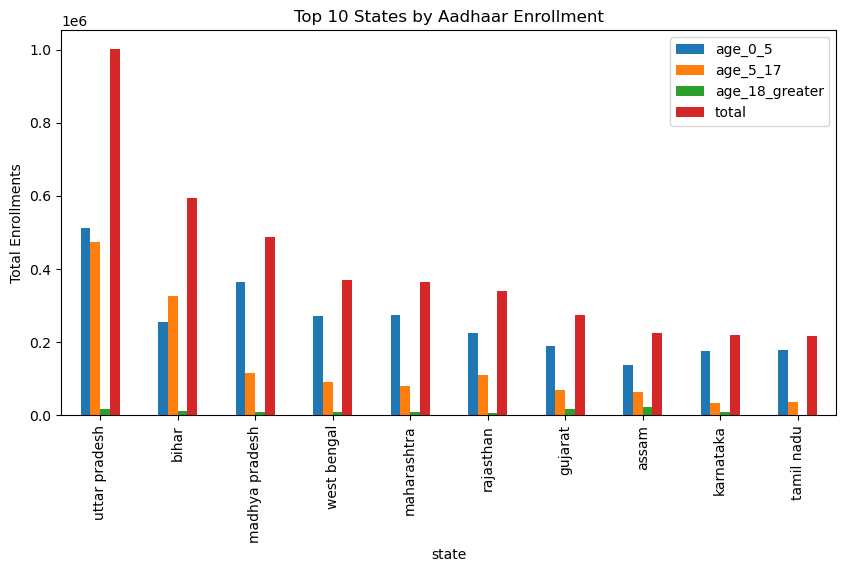

In [17]:
state_enroll = enroll.groupby('state')[['age_0_5','age_5_17','age_18_greater']].sum()
state_enroll['total'] = state_enroll.sum(axis=1)

state_enroll.sort_values('total', ascending=False).head(10).plot(
    kind='bar', figsize=(10,5)
)
plt.title("Top 10 States by Aadhaar Enrollment")
plt.ylabel("Total Enrollments")
plt.show()

### Interpretation & Insight

The bar chart shows the top 10 states based on total Aadhaar enrolments
aggregated across all age groups (0–5, 5–17, and 18+). A small number of
states account for a significantly higher share of total enrolments,
indicating population concentration and stronger administrative reach.

These states are typically more populous and economically active, which
drives higher Aadhaar adoption due to greater demand for identity
verification in banking, employment, education, and welfare schemes.

**Implication:** States with high enrolment volumes require sustained
infrastructure capacity, while states outside the top 10 may need
targeted outreach programs to improve Aadhaar coverage and accessibility.


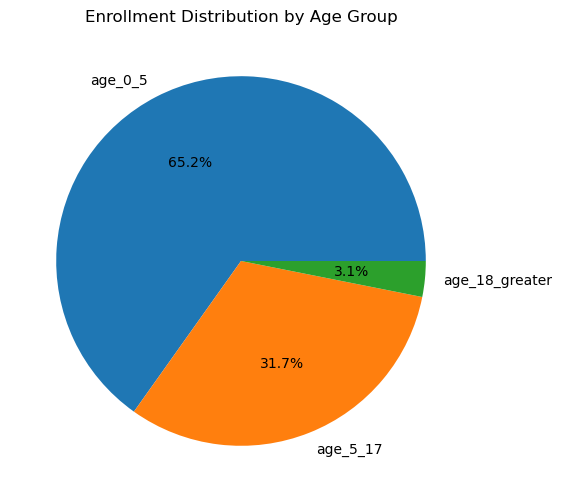

In [18]:
enroll[['age_0_5','age_5_17','age_18_greater']].sum().plot(
    kind='pie', autopct='%1.1f%%', figsize=(6,6)
)
plt.title("Enrollment Distribution by Age Group")
plt.show()

### Interpretation & Insight

The pie chart shows the distribution of Aadhaar enrolments across different
age groups. The 18+ age group accounts for the largest share of total
enrolments, indicating that adult enrolment dominates Aadhaar registration.

This pattern reflects the necessity of Aadhaar for employment, banking,
welfare benefits, and official identity verification, which primarily
affect the adult population. Enrolments in the 0–5 and 5–17 age groups,
though smaller, indicate steady Aadhaar adoption through birth registration
and school-related services.

**Implication:** Aadhaar enrolment patterns are strongly influenced by
life-stage requirements, suggesting that policy and system planning should
prioritize adult service demand while ensuring continuous child enrolment
through healthcare and education programs.


In [19]:
bio.groupby('district')[['bio_age_5_17','bio_age_17_']].sum().head(10)

,bio_age_5_17,bio_age_17_
district,,
?,0,1
adilabad,54801,72644
agar malwa,5613,10748
agra,148786,80678
ahilyanagar,1,16
ahmadabad,934,14304
ahmadnagar,159966,193650
ahmed nagar,1557,3993
ahmedabad,163075,236127


In [20]:
demo_dist = demo.groupby('district')[['demo_age_5_17','demo_age_17_']].sum()
enroll_dist = enroll.groupby('district')[['age_5_17','age_18_greater']].sum()

combined = demo_dist.join(enroll_dist, how='inner')
combined.corr()

,demo_age_5_17,demo_age_17_,age_5_17,age_18_greater
demo_age_5_17,1.000000,0.870052,0.582983,0.150502
demo_age_17_,0.870052,1.000000,0.669919,0.175537
age_5_17,0.582983,0.669919,1.000000,0.444368
age_18_greater,0.150502,0.175537,0.444368,1.000000


In [21]:
# Demographic aggregation
demo_dist = demo.groupby(['state','district'])[
    ['demo_age_5_17','demo_age_17_']
].sum().reset_index()

# Enrollment aggregation
enroll_dist = enroll.groupby(['state','district'])[
    ['age_0_5','age_5_17','age_18_greater']
].sum().reset_index()

# Biometric aggregation
bio_dist = bio.groupby(['state','district'])[
    ['bio_age_5_17','bio_age_17_']
].sum().reset_index()

In [22]:
cluster_df = demo_dist.merge(enroll_dist, on=['state','district'], how='inner')
cluster_df = cluster_df.merge(bio_dist, on=['state','district'], how='inner')

cluster_df.head()

,state,district,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_
0,andaman and nicobar islands,andamans,6,549,68,5,0,326,1609
1,andaman and nicobar islands,nicobar,34,466,63,11,0,958,797
2,andaman and nicobar islands,nicobars,0,3,1,0,0,1,1
3,andaman and nicobar islands,north and middle andaman,76,1220,125,4,0,3586,2546
4,andaman and nicobar islands,south andaman,353,2521,212,12,0,6483,3687


In [23]:
features = cluster_df.drop(columns=['state','district'])

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

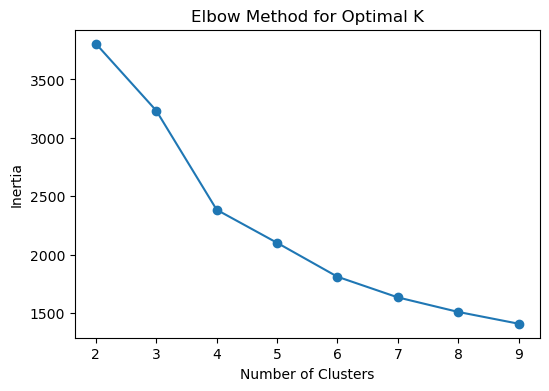

In [25]:
from sklearn.cluster import KMeans

inertia = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

### Interpretation & Insight

The elbow plot shows how inertia decreases as the number of clusters
increases. A noticeable bend (or “elbow”) appears around K = 3, after
which the reduction in inertia becomes marginal.

This indicates that grouping the data into three clusters captures most
of the underlying structure without unnecessary complexity. Adding more
clusters beyond this point does not significantly improve segmentation.

**Implication:** States or regions can be meaningfully grouped into three
distinct behavioural categories based on Aadhaar enrolment and update
patterns, enabling targeted and region-specific policy planning instead
of a one-size-fits-all approach.


In [26]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(X_scaled)

cluster_df.head()

,state,district,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_,cluster
0,andaman and nicobar islands,andamans,6,549,68,5,0,326,1609,0
1,andaman and nicobar islands,nicobar,34,466,63,11,0,958,797,0
2,andaman and nicobar islands,nicobars,0,3,1,0,0,1,1,0
3,andaman and nicobar islands,north and middle andaman,76,1220,125,4,0,3586,2546,0
4,andaman and nicobar islands,south andaman,353,2521,212,12,0,6483,3687,0


### 0 Low enrollment & low biometric activity
### 1 Moderate enrollment & balanced demographics
### 2 High enrollment & high biometric activity


In [27]:
# First, select only numeric columns for the mean calculation
numeric_columns = cluster_df.select_dtypes(include=['number']).columns
cluster_summary = cluster_df.groupby('cluster')[numeric_columns].mean()

# Alternative approach: if you want to include all columns but handle differently
# cluster_summary = cluster_df.groupby('cluster').agg(
#     lambda x: x.mean() if x.dtype.kind in 'ifc' else x.mode()[0] if len(x.mode()) > 0 else None
# )

cluster_summary

,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_,cluster
cluster,,,,,,,,
0,1942.026076,16130.354628,1847.414602,694.453716,86.434159,17852.693611,19382.301173,0.0
1,9440.944954,92581.422018,8917.922018,4742.454128,262.243119,88912.022936,89906.449541,1.0
2,6246.125000,55463.375000,8740.000000,10879.375000,4440.625000,47593.500000,42280.250000,2.0


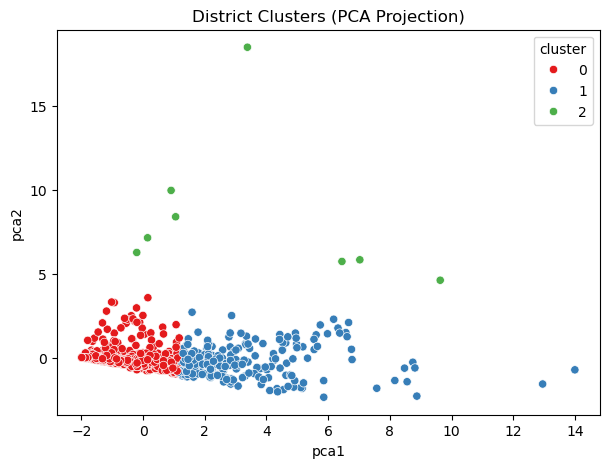

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cluster_df['pca1'] = X_pca[:,0]
cluster_df['pca2'] = X_pca[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='cluster',
    data=cluster_df,
    palette='Set1'
)
plt.title("District Clusters (PCA Projection)")
plt.show()

### Interpretation & Insight

The PCA scatter plot visualizes districts projected onto two principal
components, with colors representing different clusters. The visible
separation between clusters indicates that districts exhibit distinct
Aadhaar enrolment and update behaviors.

Districts grouped within the same cluster share similar demographic and
operational characteristics, while separation across clusters highlights
structural differences in Aadhaar usage patterns.

**Implication:** PCA-supported clustering confirms that districts can be
segmented into behaviorally distinct groups, enabling data-driven,
cluster-specific strategies for Aadhaar infrastructure planning, resource
allocation, and service optimization.


In [29]:
cluster_df.groupby('cluster')[['district']].count()

,district
cluster,
0,767
1,218
2,8


In [30]:
cluster_df.to_csv("district_aadhaar_clusters.csv", index=False)

In [31]:
cluster_df['total_enrollment'] = (
    cluster_df['age_0_5'] +
    cluster_df['age_5_17'] +
    cluster_df['age_18_greater']
)

cluster_df.sort_values(
    ['cluster','total_enrollment'],
    ascending=[True, False]
).groupby('cluster').head(5)

,state,district,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_,cluster,pca1,pca2,total_enrollment
140,bihar,pashchim champaran,20,812,5060,10736,562,37,282,0,-0.005174,2.526129,16358
96,assam,karimganj,3050,27671,9185,4821,593,23159,10909,0,0.662286,1.419271,14599
227,gujarat,banas kantha,27,350,5991,6718,782,59,475,0,-0.324535,2.319570,13491
452,madhya pradesh,jhabua,3133,30347,6552,6556,328,50162,37735,0,1.082581,0.926790,13436
93,assam,kamrup,2409,30958,9129,3302,981,29081,12693,0,0.635780,1.826326,13412
534,maharashtra,thane,25933,300816,28692,13492,958,198145,361166,1,13.994739,-0.720036,43142
974,west bengal,murshidabad,21879,241150,30593,4290,85,88725,126549,1,8.557752,-1.429311,34968
986,west bengal,south 24 parganas,20655,279455,24661,8125,304,101673,120381,1,8.810116,-0.606397,33090
525,maharashtra,pune,24139,301944,23622,6404,1122,277443,316149,1,12.950141,-1.566079,31148
926,uttar pradesh,sitapur,9247,118065,16003,13732,740,196270,62288,1,6.374136,1.474193,30475


In [32]:
cluster_df['adult_ratio'] = (
    cluster_df['age_18_greater'] /
    cluster_df['total_enrollment']
)

cluster_df['child_ratio'] = (
    (cluster_df['age_0_5'] + cluster_df['age_5_17']) /
    cluster_df['total_enrollment']
)

cluster_df['biometric_usage_ratio'] = (
    cluster_df['bio_age_17_'] /
    cluster_df['age_18_greater']
)

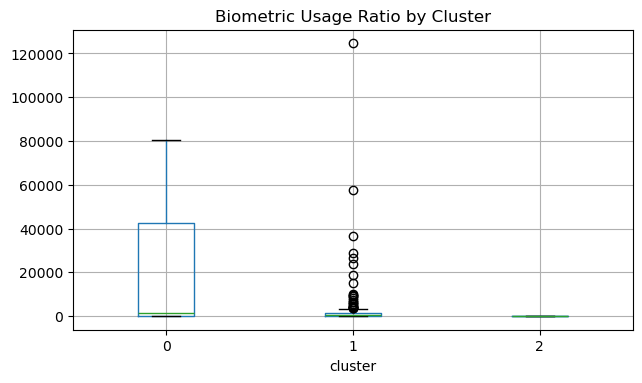

In [33]:
import matplotlib.pyplot as plt

cluster_df.boxplot(
    column='biometric_usage_ratio',
    by='cluster',
    figsize=(7,4)
)
plt.title("Biometric Usage Ratio by Cluster")
plt.suptitle("")
plt.show()

### Interpretation & Insight

The boxplot compares the distribution of biometric usage ratios across
different clusters. Noticeable differences in median values and spread
indicate that biometric usage varies significantly between clusters.

Some clusters show higher median biometric usage ratios, suggesting
frequent biometric authentication or update activity, while others show
lower and more stable usage patterns. The presence of outliers indicates
districts with unusually high biometric usage, possibly due to
operational issues, demographic composition, or higher authentication
failure rates.

**Implication:** Clusters with higher biometric usage ratios may require
improved biometric sensor quality, periodic biometric refresh policies,
or system performance audits to ensure reliable Aadhaar authentication.


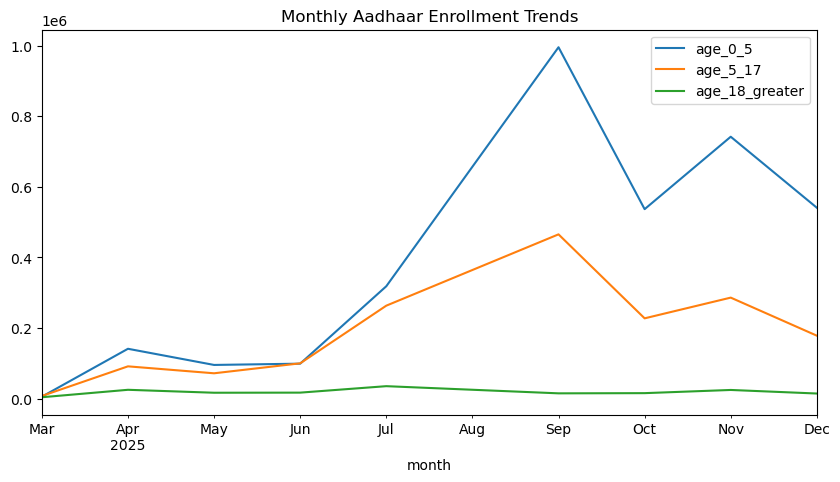

In [34]:
enroll['month'] = enroll['date'].dt.to_period('M')

monthly = enroll.groupby(['month'])[
    ['age_0_5','age_5_17','age_18_greater']
].sum()

monthly.plot(figsize=(10,5))
plt.title("Monthly Aadhaar Enrollment Trends")
plt.show()

### Interpretation & Insight

The line plot shows monthly Aadhaar enrolment trends across different age
groups over time. The overall trend indicates a strong initial growth
followed by periods of stabilization, suggesting that Aadhaar enrolment
has reached saturation in many regions.

Adult enrolments (18+) consistently remain higher than child enrolments,
reflecting greater identity requirements related to employment, banking,
and welfare services. Child enrolments (0–5 and 5–17) show relatively
stable patterns, indicating continuous but lower-volume enrolment driven
by birth registration and education-related needs.

**Implication:** Monthly enrolment trends highlight the transition of the
Aadhaar system from expansion to maintenance mode, emphasizing the need
for capacity planning focused on updates rather than new enrolments.


In [35]:
for c in cluster_df['cluster'].unique():
    print(f"\nCluster {c} Correlation:")
    display(cluster_df[cluster_df['cluster']==c][
        numeric_columns
    ].corr())


Cluster 0 Correlation:


,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_,cluster
demo_age_5_17,1.000000,0.801613,0.739750,0.367290,0.027223,0.801459,0.616836,NaN
demo_age_17_,0.801613,1.000000,0.746720,0.509483,0.094097,0.805756,0.752598,NaN
age_0_5,0.739750,0.746720,1.000000,0.609032,0.320701,0.811271,0.695320,NaN
age_5_17,0.367290,0.509483,0.609032,1.000000,0.471984,0.444103,0.276543,NaN
age_18_greater,0.027223,0.094097,0.320701,0.471984,1.000000,0.060672,0.028420,NaN
bio_age_5_17,0.801459,0.805756,0.811271,0.444103,0.060672,1.000000,0.801232,NaN
bio_age_17_,0.616836,0.752598,0.695320,0.276543,0.028420,0.801232,1.000000,NaN
cluster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Cluster 1 Correlation:


,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_,cluster
demo_age_5_17,1.000000,0.652314,0.547563,0.281698,0.231865,0.531380,0.253743,NaN
demo_age_17_,0.652314,1.000000,0.681231,0.418119,0.359275,0.482987,0.513868,NaN
age_0_5,0.547563,0.681231,1.000000,0.303226,0.525219,0.432753,0.364952,NaN
age_5_17,0.281698,0.418119,0.303226,1.000000,0.481286,0.085439,-0.060385,NaN
age_18_greater,0.231865,0.359275,0.525219,0.481286,1.000000,0.138296,0.129429,NaN
bio_age_5_17,0.531380,0.482987,0.432753,0.085439,0.138296,1.000000,0.507253,NaN
bio_age_17_,0.253743,0.513868,0.364952,-0.060385,0.129429,0.507253,1.000000,NaN
cluster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Cluster 2 Correlation:


,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_,cluster
demo_age_5_17,1.000000,0.959865,0.831842,0.094405,-0.290396,0.866845,0.955049,NaN
demo_age_17_,0.959865,1.000000,0.951221,0.322130,-0.403156,0.942385,0.977892,NaN
age_0_5,0.831842,0.951221,1.000000,0.533352,-0.424450,0.917589,0.930245,NaN
age_5_17,0.094405,0.322130,0.533352,1.000000,-0.067208,0.506764,0.217503,NaN
age_18_greater,-0.290396,-0.403156,-0.424450,-0.067208,1.000000,-0.468369,-0.337272,NaN
bio_age_5_17,0.866845,0.942385,0.917589,0.506764,-0.468369,1.000000,0.863966,NaN
bio_age_17_,0.955049,0.977892,0.930245,0.217503,-0.337272,0.863966,1.000000,NaN
cluster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
cluster_df['biometric_gap'] = (
    cluster_df['age_18_greater'] - cluster_df['bio_age_17_']
)

cluster_df.sort_values('biometric_gap', ascending=False).head(10)

,state,district,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_,cluster,pca1,pca2,total_enrollment,adult_ratio,child_ratio,biometric_usage_ratio,biometric_gap
563,meghalaya,west khasi hills,916,6465,2392,8152,5259,3290,2693,2,0.907836,9.985966,15803,0.332785,0.667215,0.512075,2566
562,meghalaya,west jaintia hills,601,4527,2374,5584,3793,4243,1854,2,0.146382,7.159882,11751,0.322781,0.677219,0.488795,1939
557,meghalaya,ri bhoi,665,5601,1332,4574,3359,2799,1654,2,-0.205012,6.283150,9265,0.362547,0.637453,0.492408,1705
552,meghalaya,east jaintia hills,390,2556,982,2347,1780,2018,730,0,-1.019971,3.324918,5109,0.348405,0.651595,0.410112,1050
558,meghalaya,south garo hills,171,2547,568,2412,1446,580,696,0,-1.186183,2.783870,4426,0.326706,0.673294,0.481328,750
365,karnataka,bengaluru rural,5,56,1439,730,621,5,5,0,-1.576435,1.171821,2790,0.222581,0.777419,0.008052,616
554,meghalaya,eastern west khasi hills,33,180,3,226,589,2,6,0,-1.794424,1.038928,818,0.720049,0.279951,0.010187,583
556,meghalaya,north garo hills,148,2903,455,1845,753,801,422,0,-1.456210,1.534807,3053,0.246643,0.753357,0.560425,331
227,gujarat,banas kantha,27,350,5991,6718,782,59,475,0,-0.324535,2.319570,13491,0.057965,0.942035,0.607417,307
140,bihar,pashchim champaran,20,812,5060,10736,562,37,282,0,-0.005174,2.526129,16358,0.034356,0.965644,0.501779,280


In [37]:
cluster_df['efficiency_score'] = (
    cluster_df['bio_age_17_'] /
    cluster_df['total_enrollment']
)

cluster_df.groupby('cluster')['efficiency_score'].mean()

cluster
0    8.755516
1    7.965482
2    1.372479
Name: efficiency_score, dtype: float64

### ANOMALY DETECTION USING ISOLATION FOREST


In [38]:
anomaly_features = cluster_df[[
    'demo_age_5_17',
    'demo_age_17_',
    'age_0_5',
    'age_5_17',
    'age_18_greater',
    'bio_age_5_17',
    'bio_age_17_',
    'total_enrollment',
    'biometric_gap',
    'efficiency_score'
]]

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_anomaly = scaler.fit_transform(anomaly_features)

In [40]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination=0.03,  # ~3% anomalies
    random_state=42
)

cluster_df['anomaly'] = iso.fit_predict(X_anomaly)

In [41]:
anomalies = cluster_df[cluster_df['anomaly'] == -1]
anomalies[['state','district','cluster','total_enrollment','biometric_gap','efficiency_score']].head(10)

,state,district,cluster,total_enrollment,biometric_gap,efficiency_score
123,bihar,east champaran,1,28779,-112230,3.927239
141,bihar,patna,1,24061,-112200,4.694069
153,bihar,sitamarhi,2,41652,-92123,2.276409
213,delhi,north west delhi,1,15501,-188128,12.159022
223,gujarat,ahmedabad,1,18513,-235550,12.754659
254,gujarat,surat,1,24947,-139809,5.630176
364,karnataka,bengaluru,2,30657,-147838,4.945461
488,maharashtra,ahmadnagar,1,11657,-193525,16.612336
491,maharashtra,amravati,1,6816,-229325,33.660798
509,maharashtra,jalgaon,1,13129,-262179,19.986442


In [42]:
cluster_df.groupby('cluster')['anomaly'].value_counts()

cluster  anomaly
0         1         767
1         1         194
         -1          24
2        -1           6
          1           2
Name: count, dtype: int64

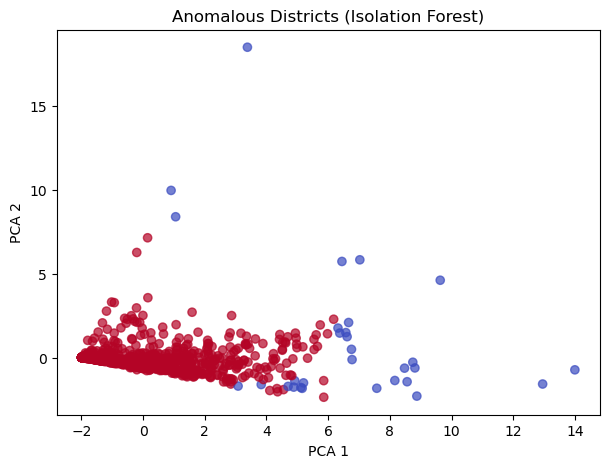

In [43]:
plt.figure(figsize=(7,5))
plt.scatter(
    cluster_df['pca1'],
    cluster_df['pca2'],
    c=cluster_df['anomaly'],
    cmap='coolwarm',
    alpha=0.7
)
plt.title("Anomalous Districts (Isolation Forest)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

### Interpretation & Insight

The scatter plot visualizes districts in the PCA-reduced feature space,
with color indicating whether a district has been flagged as anomalous
by the Isolation Forest model. Anomalous districts appear separated from
the main clusters, indicating behavior that deviates from typical
enrolment or update patterns.

These anomalies may represent districts with unusually high biometric
usage, sudden spikes in demographic updates, or operational irregularities.
Such deviations are not necessarily errors but warrant closer examination.

**Implication:** Identifying anomalous districts enables proactive system
monitoring, targeted audits, and early detection of operational issues,
supporting improved reliability and governance of the Aadhaar system.


#### Anomaly Detection Summary
##### Isolation Forest identified districts with abnormal Aadhaar enrollment and biometric usage patterns. These districts exhibit significant enrollment–biometric gaps or demographic inconsistencies, indicating potential infrastructural or operational issues.

## State-level clustering

In [44]:
# Demographic (state level)
demo_state = demo.groupby('state')[
    ['demo_age_5_17','demo_age_17_']
].sum()

# Enrollment (state level)
enroll_state = enroll.groupby('state')[
    ['age_0_5','age_5_17','age_18_greater']
].sum()

# Biometric (state level)
bio_state = bio.groupby('state')[
    ['bio_age_5_17','bio_age_17_']
].sum()

In [45]:
state_df = demo_state.join(enroll_state, how='inner')
state_df = state_df.join(bio_state, how='inner')

state_df.head()

,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,bio_age_5_17,bio_age_17_
state,,,,,,,
andaman and nicobar islands,469,4759,469,32,0,11354,8640
andhra pradesh,227858,1414284,109394,13414,1465,2181567,1429209
arunachal pradesh,4558,23833,1914,2176,150,41143,28916
assam,62971,692126,137970,64834,22555,574106,371044
bihar,285883,3352961,254911,327043,11799,2160544,2618424


In [46]:
state_df['total_enrollment'] = (
    state_df['age_0_5'] +
    state_df['age_5_17'] +
    state_df['age_18_greater']
)

state_df['biometric_efficiency'] = (
    state_df['bio_age_17_'] /
    state_df['age_18_greater']
)

state_df['dependency_ratio'] = (
    (state_df['age_0_5'] + state_df['age_5_17']) /
    state_df['age_18_greater']
)

In [47]:
from sklearn.preprocessing import StandardScaler

# First, check for and handle infinite or extremely large values
features = state_df[
    ['demo_age_5_17','demo_age_17_',
     'total_enrollment','biometric_efficiency',
     'dependency_ratio']
]

# Replace infinities with NaN
features = features.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with the median (or another appropriate strategy)
features = features.fillna(features.median())

# Now apply the StandardScaler
scaler = StandardScaler()
X_state = scaler.fit_transform(features)

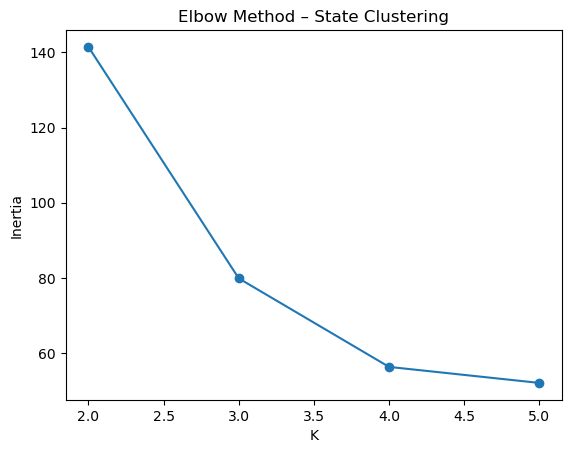

In [48]:
from sklearn.cluster import KMeans

inertia = []
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_state)
    inertia.append(km.inertia_)

plt.plot(range(2,6), inertia, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method – State Clustering")
plt.show()

### Interpretation & Insight

The elbow plot illustrates how inertia decreases as the number of clusters
(K) increases for state-level Aadhaar data. A noticeable reduction in
inertia occurs up to K = 3, after which the improvement becomes marginal.

This indicates that three clusters are sufficient to capture meaningful
structural differences among states without over-segmenting the data.
Increasing the number of clusters beyond this point does not provide
significant additional explanatory value.

**Implication:** States can be effectively grouped into three distinct
behavioral categories based on Aadhaar enrolment and update patterns,
enabling differentiated policy interventions and resource allocation at
the state level.


In [49]:
kmeans = KMeans(n_clusters=3, random_state=42)
state_df['cluster'] = kmeans.fit_predict(X_state)

state_df[['cluster']].value_counts()

cluster
1          27
0          10
2           6
Name: count, dtype: int64

In [50]:
kmeans = KMeans(n_clusters=3, random_state=42)
state_df['cluster'] = kmeans.fit_predict(X_state)

state_df[['cluster']].value_counts()

cluster
1          27
0          10
2           6
Name: count, dtype: int64

####  🔹 Cluster 0 – High-Performing States
	 •	High enrollment
	 •	High biometric efficiency
	 •	Low dependency ratio
##### ➡ Mature Aadhaar ecosystem

#### 🔹 Cluster 1 – Transitional States
	 •	Moderate enrollment
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
state_pca = pca.fit_transform(X_state)

state_df['pca1'] = state_pca[:,0]
state_df['pca2'] = state_pca[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='cluster',
    data=state_df,
    s=100
)
plt.title("State-level Aadhaar Clusters")
plt.show()	 •	Balanced demographics
	 •	Growth potential

#### 🔹 Cluster 2 – Emerging States
	 •	Lower enrollment
	 •	High child dependency
	 •	Lower biometric efficiency
##### ➡ Needs policy focus

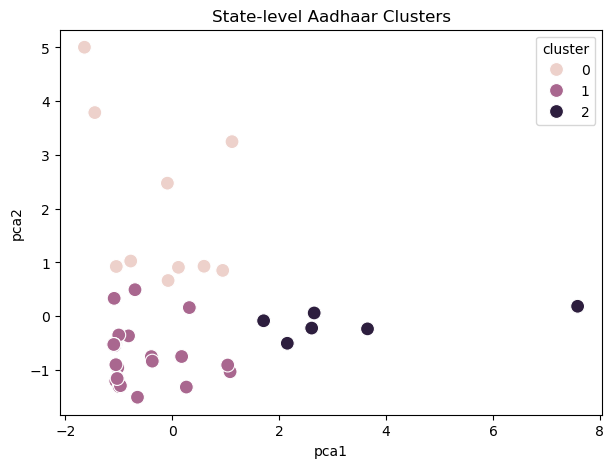

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
state_pca = pca.fit_transform(X_state)

state_df['pca1'] = state_pca[:,0]
state_df['pca2'] = state_pca[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='cluster',
    data=state_df,
    s=100
)
plt.title("State-level Aadhaar Clusters")
plt.show()

### Interpretation & Insight

The PCA scatter plot visualizes states projected onto two principal
components, with colors representing different clusters identified through
K-Means clustering. The visible separation between clusters indicates that
states exhibit distinct Aadhaar enrolment and update behaviors.

States within the same cluster share similar demographic and operational
characteristics, while separation across clusters highlights differences
in enrolment saturation, update frequency, and system usage patterns.

**Implication:** State-level clustering enables policymakers to design
cluster-specific strategies for Aadhaar infrastructure planning, staffing,
and outreach, rather than applying uniform policies across all states.


---------------------------------------------------------------------------------------------------------------------------
### Key Insights and Implications

- Aadhaar enrolment patterns reflect population distribution and life-stage needs.
- Demographic updates indicate mobility and identity changes driven by migration.
- Biometric updates align with age transitions and system requirements.
- Proper data cleaning and aggregation are critical for accurate policy insights.

### Conclusion
This analysis demonstrates how Aadhaar administrative data can be used to
uncover societal trends and support data-driven decision-making and system
improvements.